In [71]:
import torch
import sigkernel
import numpy as np
import matplotlib.pyplot as plt

In [72]:
weights = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

In [73]:
verification = torch.rand(1,7,32,64,1)
forecast = torch.rand(3,7,32,64,1)

In [108]:
# vals = []
# print(forecast.shape)
# print(verification.shape)
# forecast = forecast.squeeze(-1)         # [E, T, 32, 64]
# verification = verification.squeeze(-1) # [1, T, 32, 64]print(forecast.shape)
# forecast = forecast.permute(2, 0, 1, 3)         # [32, E, T, 64]
# verification = verification.permute(2, 0, 1, 3) # [32, 1, T, 64]
vals = []
verification = torch.rand(1,7,32)
forecast = torch.rand(3,7,32)
print(forecast.shape)
print(verification.shape)

for i in range(forecast.shape[1]):
    #print(i)
    forcasttemp = forecast[:,i,:]
    verificationtemp = verification[:,i,:]
    forcasttemp = forcasttemp.unsqueeze(0)
    #print(forcasttemp.shape)
    #print(verificationtemp.shape)


    batch_size, ensemble_size, data_size = forcasttemp.shape

    diff_X_y = torch.cdist(verificationtemp.reshape(batch_size, 1, data_size), forcasttemp, p=2)
    diff_X_y = torch.squeeze(diff_X_y, dim=1)

    diff_X_tildeX = torch.cdist(forcasttemp, forcasttemp, p=2)

    if 1 != 1:
        diff_X_tildeX = torch.pow(diff_X_tildeX, 1)
        diff_X_y = torch.pow(diff_X_y, 1)

    result = 2 * torch.sum(torch.mean(diff_X_y, dim=1)) - torch.sum(diff_X_tildeX) / (
            ensemble_size * (ensemble_size - 1))

    if True:
        result /= verificationtemp.shape[0]
    
    vals.append(result)
    
torchvals = torch.stack(vals, dim=0).mean(dim=0)



torch.Size([3, 7, 32])
torch.Size([1, 7, 32])


In [103]:
torchvals

tensor(2.1535)

In [97]:
verification = torch.rand(1,7,32,64,1)
forecast = torch.rand(3,7,32,64,1)

torch.Size([3, 7, 32, 64, 1])

In [116]:
verification = torch.rand(1,7,32,64,1)
forecast = torch.rand(3,7,32,64,1)

verification = verification.squeeze(-1)
forecast = forecast.squeeze(-1)

vals = []
for lat in range(forecast.shape[2]):
    veriflat = verification[:,:,lat,:]
    forelat = forecast[:,:,lat,:]

    forelat = forelat.permute(1, 0, 2)           # (pathlength, ensemble, dims)
    veriflat = veriflat.permute(1, 0, 2)   # (pathlength, 1, dims)

    # Compute pairwise distances for each timestep across batch dimension
    # diff_X_y: (pathlength, ensemble)
    diff_X_y = torch.cdist(veriflat, forelat, p=2).squeeze(1)

    # diff_X_tildeX: (pathlength, ensemble, ensemble)
    diff_X_tildeX = torch.cdist(forelat, forelat, p=2)

    ensemble_size = forelat.shape[1]

    # Energy score per timestep
    # (pathlength,)
    energy_scores = (
        2 * diff_X_y.mean(dim=1) -
        diff_X_tildeX.sum(dim=(1, 2)) / (ensemble_size * (ensemble_size - 1))
    )

    # Average over all path steps
    torchvals = energy_scores.mean()
    vals.append(torchvals)

sum(vals*weights)

104.42754169303812

In [119]:
# verification: (1, 7, 32, 64, 1)
# forecast: (3, 7, 32, 64, 1)
# weights: (32,) or (32, 1) — make sure it's a torch tensor on same device

verification = torch.rand(1,7,32,64,1)
forecast = torch.rand(3,7,32,64,1)

verification = verification.squeeze(-1)  # (1, 7, 32, 64)
forecast = forecast.squeeze(-1)          # (3, 7, 32, 64)

vals = []

for lat in range(forecast.shape[2]):
    veriflat = verification[:, :, lat, :]  # (1, 7, 64)
    forelat = forecast[:, :, lat, :]       # (3, 7, 64)

    forelat = forelat.permute(1, 0, 2)     # (pathlength=7, ensemble=3, dims=64)
    veriflat = veriflat.permute(1, 0, 2)   # (pathlength=7, 1, dims=64)

    # diff_X_y: (7, 3)
    diff_X_y = torch.cdist(veriflat, forelat, p=2).squeeze(1)
    diff_X_tildeX = torch.cdist(forelat, forelat, p=2)  # (7, 3, 3)

    ensemble_size = forelat.shape[1]

    energy_scores = (
        2 * diff_X_y.mean(dim=1) -
        diff_X_tildeX.sum(dim=(1, 2)) / (ensemble_size * (ensemble_size - 1))
    )

    mean_score = energy_scores.mean()  # (scalar tensor)
    vals.append(mean_score)

# Convert vals to tensor: (32,)
energy_scores_lat = torch.stack(vals, dim=0)

# Make sure weights is a torch tensor of shape (32,) on same device
# Example: weights = torch.ones(32, device=forecast.device)

# Weighted sum (with grad support)
weighted_score = (energy_scores_lat * weights.squeeze()).sum()


In [120]:
weighted_score

tensor(105.3124, dtype=torch.float64)

In [98]:

ensemble_size = forecast.shape[0]

# Reshape to group path_length, lon into a single spatial dimension
# new shape: (ensemble, 32, 7*64, 1)
forecast_flat = forecast.permute(0, 2, 1, 3, 4).reshape(ensemble_size, 32, -1, 1)
observation_flat = verification.permute(0, 2, 1, 3, 4).reshape(1, 32, -1, 1)

print(forecast_flat.shape)
print(observation_flat.shape)
# Compute energy score per latitude
# Loop over latitudes (vectorizing over other dimensions)
energy_scores = []
for lat in range(32):
    f_lat = forecast_flat[:, lat, :, :]        # (ensemble, spatial_points, 1)
    o_lat = observation_flat[:, lat, :, :]     # (1, spatial_points, 1)

    # Compute pairwise distances
    diff_X_y = torch.cdist(o_lat, f_lat, p=2).squeeze(0).mean(dim=1)
    diff_X_tildeX = torch.cdist(f_lat, f_lat, p=2)
    
    score = 2 * diff_X_y.mean() - diff_X_tildeX.sum() / (ensemble_size * (ensemble_size - 1))
    energy_scores.append(score)

# Stack into tensor: (32,)
energy_scores = torch.stack(energy_scores)

torch.Size([3, 32, 448, 1])
torch.Size([1, 32, 448, 1])


In [99]:
sum(energy_scores)

tensor(-1064149.3750)

In [88]:
torchvals

tensor(2.1358)

In [59]:
verification.shape

torch.Size([1, 7, 32, 64, 1])

In [70]:
for i in range(200):
    verification = (verification- verification.mean()) / verification.std()
    forecast = (forecast- forecast.mean()) / forecast.std()

    #print(forecast[0,:,0])

    static_kernel = sigkernel.RBFKernel(sigma=1) #LinearKernel?
    dyadic_order = 1
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

    latitudes = forecast.shape[2]
    totalscore = []
    #print("before latloop")
    for latitude in range(latitudes):
        verificationlat = verification[:,:,latitude,:,:].squeeze(-1)
        forecastlat = forecast[:,:,latitude,:,:].squeeze(-1)

        #Sig kernels transform function requires sending to numpy which can't work.
        batch_size, seq_len, feature_dim = forecastlat.shape


        zerosX = torch.zeros(batch_size, 1, feature_dim, device=forecastlat.device)
        zerosY = torch.zeros(1, 1, feature_dim, device=forecastlat.device)
        #forecast  # Shape: [batch_size, 1, feature_dim]
        X = torch.cat([zerosX, forecastlat], dim=1)
        y = torch.cat([zerosY, verificationlat], dim=1)

                #1) Create a time vector, shape [seq_len]
        time_vec = torch.linspace(0, 1, steps=seq_len+1, device=forecastlat.device)
        # 2) Reshape to match x's batch and sequence dimensions
        #    We want [batch_size, seq_len, 1], so we expand along batch dimension
        time_vec = time_vec.unsqueeze(0).unsqueeze(-1)  # now [1, seq_len, 1]

        y = torch.cat([y, time_vec], dim=-1)
        time_vec = time_vec.expand(batch_size, seq_len+1, 1)  # now [batch_size, seq_len, 1]
        X = torch.cat([X, time_vec], dim=-1)

        X = X.double()
        y = y.double()

        score = signature_kernel.compute_scoring_rule(X,y)
        totalscore.append(score*weights[latitude])
    #print(score)
    #requires double, not float?
    totalscore = torch.stack(totalscore).sum()

In [57]:
totalscore

tensor(-72.9731, dtype=torch.float64)

In [69]:
for i in range(200):
        verification = (verification- verification.mean()) / verification.std()
        forecast = (forecast- forecast.mean()) / forecast.std()

        #print(forecast[0,:,0])

        static_kernel = sigkernel.RBFKernel(sigma=1) #LinearKernel?
        dyadic_order = 1
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

        latitudes = forecast.shape[2]

        verificationlat = verification.reshape(1, 7, 32 * 64, 1).squeeze(-1)
        forecastlat = forecast.reshape(3, 7, 32 * 64, 1).squeeze(-1)
        
        #Sig kernels transform function requires sending to numpy which can't work.
        batch_size, seq_len, feature_dim = forecastlat.shape


        zerosX = torch.zeros(batch_size, 1, feature_dim, device=forecastlat.device)
        zerosY = torch.zeros(1, 1, feature_dim, device=forecastlat.device)
        #forecast  # Shape: [batch_size, 1, feature_dim]
        X = torch.cat([zerosX, forecastlat], dim=1)
        y = torch.cat([zerosY, verificationlat], dim=1)

                #1) Create a time vector, shape [seq_len]
        time_vec = torch.linspace(0, 1, steps=seq_len+1, device=forecastlat.device)
        # 2) Reshape to match x's batch and sequence dimensions
        #    We want [batch_size, seq_len, 1], so we expand along batch dimension
        time_vec = time_vec.unsqueeze(0).unsqueeze(-1)  # now [1, seq_len, 1]

        y = torch.cat([y, time_vec], dim=-1)
        time_vec = time_vec.expand(batch_size, seq_len+1, 1)  # now [batch_size, seq_len, 1]
        X = torch.cat([X, time_vec], dim=-1)

        X = X.double()
        y = y.double()

        score = signature_kernel.compute_scoring_rule(X,y)

In [64]:
score*32

tensor(-72.9731, dtype=torch.float64)

In [52]:
import torch
from functorch import vmap
import sigkernel

# Normalize forecast and verification
verification = (verification - verification.mean()) / verification.std()
forecast = (forecast - forecast.mean()) / forecast.std()

# Forecast shape: [E, T, Lat, Lon, 1]
# Verification shape: [1, T, Lat, Lon, 1]
E, T, Lat, Lon, _ = forecast.shape

# Move Lat to batch dimension
forecast = forecast.permute(2, 0, 1, 3, 4).squeeze(-1)       # [Lat, E, T, Lon]
verification = verification.permute(2, 0, 1, 3, 4).squeeze(-1)  # [Lat, 1, T, Lon]

# Pad with zeros
zerosX = torch.zeros(Lat, E, 1, Lon, device=forecast.device)
zerosY = torch.zeros(Lat, 1, 1, Lon, device=forecast.device)
X = torch.cat([zerosX, forecast], dim=2)      # [Lat, E, T+1, Lon]
Y = torch.cat([zerosY, verification], dim=2)  # [Lat, 1, T+1, Lon]

# Add time channel
time_vec = torch.linspace(0, 1, steps=T+1, device=forecast.device)
time_vec = time_vec[None, None, :, None]  # [1,1,T+1,1]
time_vec_X = time_vec.expand(Lat, E, T+1, 1)   # [Lat, E, T+1, 1]
time_vec_Y = time_vec.expand(Lat, 1, T+1, 1)   # [Lat, 1, T+1, 1]

X = torch.cat([X, time_vec_X], dim=-1)   # [Lat, E, T+1, Lon+1]
Y = torch.cat([Y, time_vec_Y], dim=-1)   # [Lat, 1, T+1, Lon+1]

X = X.double()
Y = Y.double()

# Setup kernel
static_kernel = sigkernel.RBFKernel(sigma=1)
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)

# Scoring function
def scoring_fn(x, y):
    return signature_kernel.compute_scoring_rule(x.unsqueeze(0), y.unsqueeze(0))

# Apply vmap over ensemble and latitude
batched_scoring = vmap(vmap(scoring_fn, in_dims=(0, None)), in_dims=(0, 0))
scores = batched_scoring(X, Y)  # [Lat, E]

# Average over ensemble and apply weights
scores = scores.mean(dim=1)  # [Lat]
totalscore = (scores * weights).sum()


C:\Users\arche\AppData\Local\Temp\ipykernel_27200\3552684966.py:44: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  batched_scoring = vmap(vmap(scoring_fn, in_dims=(0, None)), in_dims=(0, 0))
C:\Users\arche\AppData\Local\Temp\ipykernel_27200\3552684966.py:44: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  batched_scoring = vmap(vmap(scor

RuntimeError: In order to use an autograd.Function with functorch transforms (vmap, grad, jvp, jacrev, ...), it must override the setup_context staticmethod. For more details, please see https://pytorch.org/docs/main/notes/extending.func.html

In [16]:
forecast = forecast.unsqueeze(0)
verification = verification.unsqueeze(0)

In [20]:
verification = verification.squeeze(0)

In [21]:
verification.shape

torch.Size([1, 7, 32, 64, 1])

In [22]:
static_kernel = sigkernel.RBFKernel(sigma=1)  # or a different kernel
dyadic_order = 1
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

B, E, seq_len, lat, lon, _ = forecast.shape

# Rearrange so that the latitude dimension is merged into the batch dimension.
# For forecast: from [B, E, seq_len, lat, lon, 1] to [B*lat, E, seq_len, lon, 1]
forecast_v = forecast.permute(0, 3, 1, 2, 4, 5).reshape(B * lat, E, seq_len, lon, 1)
# For verification: from [B, seq_len, lat, lon, 1] to [B*lat, seq_len, lon, 1]
verification_v = verification.permute(0, 2, 1, 3, 4).reshape(B * lat, seq_len, lon, 1)

# Remove the trailing singleton channel (now shape [B*lat, E, seq_len, lon] and [B*lat, seq_len, lon])
forecast_v = forecast_v.squeeze(-1)
verification_v = verification_v.squeeze(-1)

# (Optional) Average over longitude if you wish to collapse that dimension:
# Otherwise, you could leave the lon dimension as part of the feature dimension.
# For example, here we average over lon:
forecast_v = forecast_v.mean(dim=-1)      # now [B*lat, E, seq_len]
verification_v = verification_v.mean(dim=-1)  # now [B*lat, seq_len]

# Flatten the ensemble dimension into the batch for processing.
# Now each row corresponds to one ensemble member of one latitude slice.
forecast_v = forecast_v.reshape(B * lat * E, seq_len)         # [B*lat*E, seq_len]
# For verification, we assume the same observation is used for each ensemble member:
verification_v = verification_v.unsqueeze(1).expand(B * lat, E, seq_len)
verification_v = verification_v.reshape(B * lat * E, seq_len)   # [B*lat*E, seq_len]

# Insert a zero at the beginning along the time axis:
zeros_forecast = torch.zeros(B * lat * E, 1, device=forecast.device, dtype=forecast.dtype)
zeros_verif = torch.zeros(B * lat * E, 1, device=verification.device, dtype=verification.dtype)
X = torch.cat([zeros_forecast, forecast_v], dim=1)  # [B*lat*E, seq_len+1]
Y = torch.cat([zeros_verif, verification_v], dim=1)   # [B*lat*E, seq_len+1]

# Create a time vector and append as an extra feature.
time_vec = torch.linspace(0, 1, steps=seq_len+1, device=forecast.device, dtype=forecast.dtype)
time_vec = time_vec.unsqueeze(0).unsqueeze(-1)  # [1, seq_len+1, 1]
time_vec = time_vec.expand(B * lat * E, seq_len+1, 1)  # [B*lat*E, seq_len+1, 1]
X = torch.cat([X.unsqueeze(-1), time_vec], dim=-1)  # [B*lat*E, seq_len+1, 2]
Y = torch.cat([Y.unsqueeze(-1), time_vec], dim=-1)  # [B*lat*E, seq_len+1, 2]

# Convert to double if required by the kernel:
X = X.double()
Y = Y.double()

# Compute the score for all latitude slices (and ensemble members) in one call.
scores = signature_kernel.compute_scoring_rule(X, Y)
# Assume that scores is a tensor of shape [B*lat*E] or a scalar per sample.
# For example, you might get a score per sample which you then average over ensemble.

# Reshape to [B, lat, E] so that you can weight over latitude.
scores = scores.reshape(B, lat, E)
# Average over the ensemble dimension:
scores = scores.mean(dim=-1)  # now [B, lat]

# Weight each latitude slice by self.weights, assumed to be a tensor of shape [lat].
# Expand weights to match batch:
weighted_scores = scores * weights.unsqueeze(0)  # [B, lat]

# Sum (or average) over latitudes, then average over the batch.
totalscore = weighted_scores.sum(dim=-1)
print(totalscore)

RuntimeError: shape '[1, 32, 3]' is invalid for input of size 1

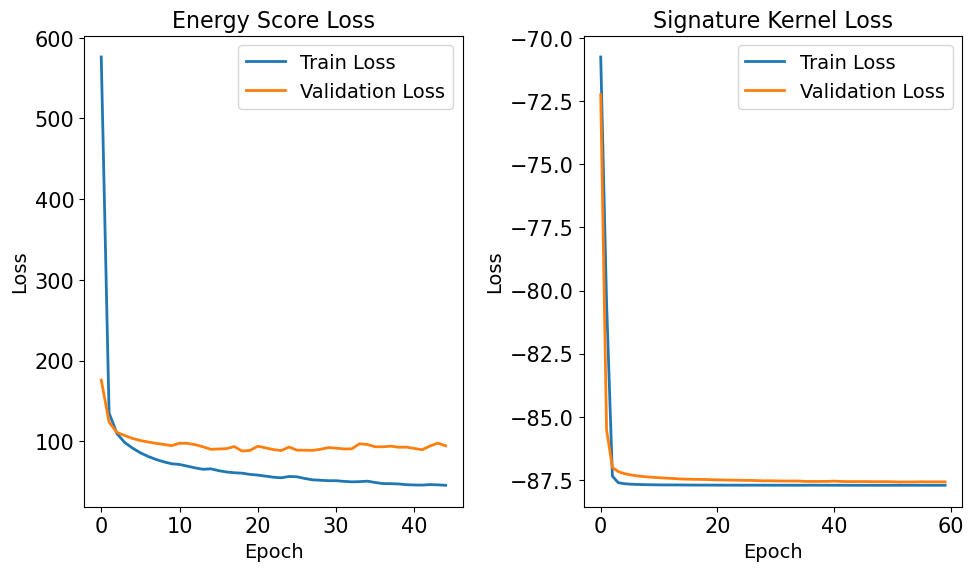

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Increase default font sizes
plt.rcParams.update({'font.size': 15})

# Load data for Energy Score
energy_train = np.load("results/nets/train_loss_mytrainedmodelEnergyScore.npy")
energy_val   = np.load("results/nets/val_loss_mytrainedmodelEnergyScore.npy")

# Load data for Signature Kernel Score
sig_train = np.load("results/nets/train_loss_mytrainedmodelSignatureKernel.npy")
sig_val   = np.load("results/nets/val_loss_mytrainedmodelSignatureKernel.npy")

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Energy Score plot
axes[0].plot(energy_train, label="Train Loss", linewidth=2)
axes[0].plot(energy_val, label="Validation Loss", linewidth=2)
axes[0].set_title("Energy Score Loss", fontsize=16)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].legend(fontsize=14)

# Signature Kernel Score plot
axes[1].plot(sig_train, label="Train Loss", linewidth=2)
axes[1].plot(sig_val, label="Validation Loss", linewidth=2)
axes[1].set_title("Signature Kernel Loss", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Loss", fontsize=14)
axes[1].legend(fontsize=14)

plt.tight_layout()

plt.subplots_adjust(bottom=0.35)  # Make room for the table

plt.show()

In [7]:
weights = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])
weights.sum()

31.999999960000004

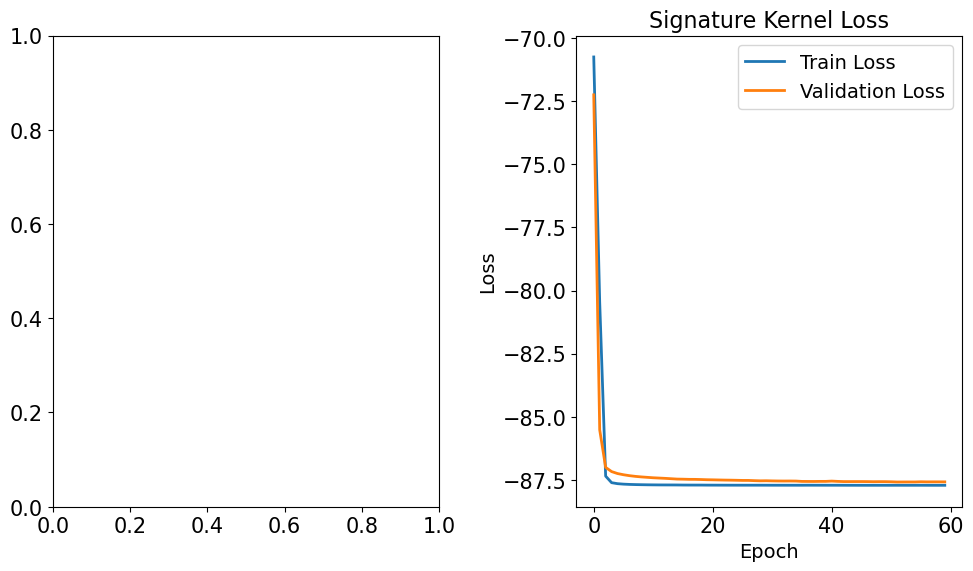

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Increase default font sizes
plt.rcParams.update({'font.size': 15})

# # Load data for Energy Score
# energy_train = np.load("results/nets/train_loss_mytrainedmodelEnergyScore.npy")
# energy_val   = np.load("results/nets/val_loss_mytrainedmodelEnergyScore.npy")

# Load data for Signature Kernel Score
sig_train = np.load("results/nets/train_loss_mytrainedmodelSignatureKernel.npy")
sig_val   = np.load("results/nets/val_loss_mytrainedmodelSignatureKernel.npy")

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# # Energy Score plot
# axes[0].plot(energy_train, label="Train Loss", linewidth=2)
# axes[0].plot(energy_val, label="Validation Loss", linewidth=2)
# axes[0].set_title("Energy Score Loss", fontsize=16)
# axes[0].set_xlabel("Epoch", fontsize=14)
# axes[0].set_ylabel("Loss", fontsize=14)
# axes[0].legend(fontsize=14)

# Signature Kernel Score plot
axes[1].plot(sig_train, label="Train Loss", linewidth=2)
axes[1].plot(sig_val, label="Validation Loss", linewidth=2)
axes[1].set_title("Signature Kernel Loss", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Loss", fontsize=14)
axes[1].legend(fontsize=14)

plt.tight_layout()

plt.subplots_adjust(bottom=0.35)  # Make room for the table

plt.show()

In [ ]:
\begin{frame}
	\frametitle{Training}
    \begin{center}
  \begin{figure}
        \includegraphics[width=1\linewidth]{Losses.png}
        \caption{Evidence for further training of Signature Kernel}
        \end{figure}
	%	\bigskip% Vertical whitespace
		%{\LARGE Questions? Comments?}
	\end{center}
\end{frame}

FileNotFoundError: [Errno 2] No such file or directory: 'results/nets/train_loss_mytrainedmodelEnergyScoreLowLR.npy'

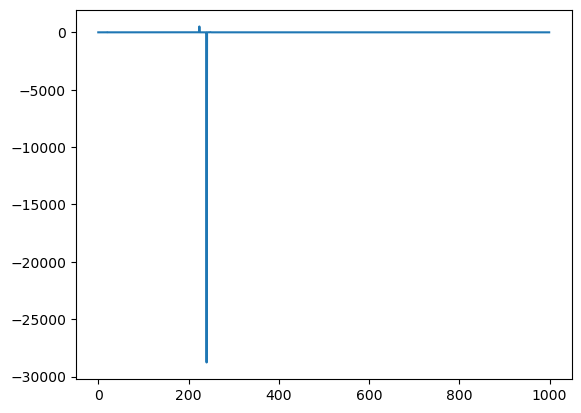

In [2]:
vals = np.load("losstrainvalues.npy")
plt.plot(vals)
plt.show()

In [ ]:
values = np.asarray([-2.2864075790752065, -2.3259188912131568, -2.4721521897749468, -2.722275278785012, -2.9143636443398218, -2.9999571496790107, -3.117465387691151, -3.2501299381256104, -3.433055942708796, -3.5176493254574863, -3.8553863005204634, -3.8697624640031294, -3.880287690596147, -3.891389239918102, -3.8817249861630527, -3.8632797544652764, -3.8814070441506128, -3.880549669265747, -3.8800565762953325, -3.8682949326255103, -3.857734355059537, -3.8458391319621694, -3.892436461015181, -3.865099148316817, -3.892849933017384, -3.859250935641202, -3.8893735842271284, -3.8727591037750244, -3.859089569611983, -3.863690354607322, -3.8798887079412285, -3.861679098822854, -3.8885848088697954, -3.8638120131059126, -3.8797691518610176, -3.8746061758561567, -3.892652294852517, -3.842494162646207, -3.8886536143042822, -3.8551407293839888, -3.8653922080993652, -3.8939665014093574, -3.872945720499212, -3.884467059915716, -3.8823527206074107, -3.8615570718591865, -3.916124040430242, -3.8490268967368384, -3.8855556574734775, -3.9353912743655117, -3.874634699387984, -3.883529294620861, -3.8807120756669478, -3.859342184933749, -3.852471936832775, -3.8610426729375664, -3.883354750546542, -3.903782281008634, -3.864155791022561, -3.8615035360509697, -3.8706823479045522, -3.894513325257735, -3.8880315043709497, -3.859629522670399, -3.8776134144176138, -3.863119298761541, -3.8904111602089624, -3.8954075466502798, -3.893307078968395, -3.8694582852450283, -3.881764065135609, -3.876265114003962, -3.8718783638694068, -3.862411607395519, -3.879242766987194, -3.853174556385387, -3.861184987154874, -3.8919144543734463, -3.8670735359191895, -3.885230476205999, -3.860474933277477, -3.8947197740728203, -3.8890651789578525, -3.8654657277193936, -3.8919492201371626, -3.8909295688975942, -3.8802282593467017, -3.8538032445040615, -3.8787493489005347, -3.8680402365597812, -3.884570078416304, -3.892853996970437, -3.8720644387331875, -3.886189005591653, -3.8672796379436147, -3.8657364411787554, -3.860969001596624, -3.890283454548229, -3.8646046681837602, -3.8780800212513316, -3.8513565930453213, -3.895526560870084, -3.8965881954539907, -3.870438120581887, -3.862811717120084, -3.90481255271218, -3.8756958788091485, -3.882617408579046, -3.9006032293493096, -3.874016696756536, -3.8928464325991543, -3.8831544572656806, -3.874920888380571, -3.876480752771551, -3.8823882233012807, -3.856248292055997, -3.87727427482605, -3.9091088338331743, -3.8957262472672896, -3.8579834374514492, -3.857155539772727, -3.8767180226065894, -3.8834656585346568, -3.896666245027022, -3.868370619687167, -3.869972575794567, -3.873076915740967, -3.878807783126831, -3.8630439801649614, -3.9041672836650503, -3.862329743125222, -3.861234361475164, -3.9213943047956987, -3.8756118687716397, -3.8732973012057217, -3.875675743276423, -3.9015577272935347, -3.8763647729700264, -3.870261560786854, -3.885945970361883, -3.866610527038574, -3.8651814460754395, -3.876960212534124, -3.8721533688631924, -3.8755434426394375, -3.8821944540197197, -3.852063677527688, -3.8847277597947554, -3.873122822154652, -3.922308770093051, -3.8612762581218374, -3.856310627677224, -3.89878832210194, -3.842946074225686, -3.8307258649305864, -3.8993666388771753, -3.856528412212025, -3.892302144657482, -3.868508078835227, -3.852496775713834, -3.869260787963867, -3.876808665015481, -3.8779195005243476, -3.889090733094649, -3.8766321268948642, -3.865982315757058, -3.891179908405651, -3.8736905618147417, -3.8561690720644863, -3.875727653503418, -3.8496543927626177, -3.8827879428863525, -3.869498274543069, -3.8603861765428023, -3.8614467707547275, -3.866561434485696, -3.888792493126609, -3.8854289705103096, -3.8766992308876733, -3.8591667955571953, -3.8636978322809394, -3.895642714066939, -3.904795213179155, -3.8605170249938965, -3.8650736808776855, -3.900644822554155, -3.894718972119418, -3.8866458372636274, -3.8734465512362393, -3.8474103970961138, -3.8475009094585073, -3.873633774844083, -3.87034518068487, -3.858067815954035, -3.871755426580256, -3.8811734806407583, -3.880692395296964, -3.866349632089788, -3.8669619126753374, -3.874906236475164, -3.873143802989613, -3.8824297298084605, -3.8641790476712314, -3.8904328779740767, -3.898755355314775, -3.8892146240581167, -3.8680821548808706, -3.8617551760240034, -3.890367464585738, -3.879792235114358, -3.8760364922610195, -3.873657074841586, -3.8873202150518242, -3.861202933571555, -3.878104795109142, -3.876914717934348, -3.85413798418912, -3.876891547983343, -3.8858446207913486, -3.8984354626048696, -3.86363131349737, -3.888991442593661, -3.8704898790879683, -3.881422519683838, -3.8834011554718018, -3.8788265748457476, -3.877724625847556, -3.87282995744185, -3.8768774379383433, -3.912709431214766, -3.8718542835929175, -3.8674628626216543, -3.881887999447909, -3.878899032419378, -3.8544628620147705, -3.880297985943881, -3.8715805140408603, -3.8852621642026035, -3.874150341207331, -3.8846673423593696, -3.881353811784224, -3.8824887058951636, -3.8866945830258457, -3.8739881082014604, -3.8581158247860996, -3.8707873171026055, -3.8668584390120073, -3.8948342583396216, -3.8870857628909024, -3.909241567958485, -3.8640928268432617, -3.876813931898637, -3.8591752485795454, -3.887274677103216, -3.9021294116973877, -3.8606750531630083, -3.8796248219229956, -3.857988400892778, -3.902244286103682, -3.882971828634089, -3.867223782972856, -3.8595325730063696, -3.864865172993053, -3.882923039523038, -3.8899659243496982, -3.8663757714358242, -3.8672646175731313, -3.8658335534009067, -3.922181476246227, -3.865237452767112, -3.844402876767245, -3.860273924740878, -3.8667841391129927, -3.8895620432767, -3.858249079097401, -3.8877146677537398, -3.8666723641482266, -3.8622028827667236, -3.8695490143515845, -3.8650194839997725, -3.91233905878934, -3.8839282122525303, -3.8746344176205723, -3.8702830618078057, -3.8516879081726074, -3.8737465034831655, -3.8692220991308037, -3.8578862168572168, -3.868793856013905, -3.8684826547449287, -3.865376819263805, -3.872007651762529, -3.8773901029066606, -3.8928388465534556, -3.8806600353934546, -3.9224376028234307, -3.8707686987790195, -3.8623709245161577, -3.882663856853138, -3.8533079624176025, -3.85818134654652, -3.8766178001057017, -3.8584485704248603, -3.869622967459939, -3.887334693561901, -3.9092912023717705, -3.8948479999195444, -3.8690384301272305, -3.874079465866089, -3.881145303899592, -3.880543925545432, -3.898593371564692, -3.8800653544339267, -3.871308521790938, -3.8878294337879526, -3.8981435298919678, -3.89345645904541, -3.8888709978623823, -3.8535246632315894, -3.879276232285933, -3.866477034308694, -3.900129491632635, -3.869567957791415, -3.852599252354015, -3.8849613016301934, -3.8726657303896816, -3.905269644477151, -3.8667577613483775, -3.886244622143832, -3.8685636303641577, -3.8721544525840064, -3.890770608728582, -3.8823976733467798, -3.861080754886974, -3.8627302646636963, -3.8890658617019653, -3.8857317621057685, -3.89331299608404, -3.8693537495353003, -3.854766152121804, -3.8597714467482134, -3.883764050223611, -3.88542255488309, -3.8749389214949175, -3.8893909454345703, -3.8751929023049096, -3.8728387355804443, -3.861141096461903, -3.879030401056463, -3.8927458199587734, -3.8819222450256348, -3.863510500301014, -3.869977127421986, -3.8526652292771773, -3.907600988041271, -3.8945755741812964, -3.8790441859852183, -3.86855073408647, -3.86775786226446, -3.8658325238661333, -3.8878300189971924, -3.8772004517641934, -3.872576735236428, -3.891090154647827, -3.8658145557750356, -3.8736928809772837, -3.8961821686137807, -3.8622282309965654, -3.861755912954157, -3.8814197453585537, -3.863348592411388, -3.8707459406419233, -3.8792316913604736, -3.9071570092981514, -3.908756212754683, -3.8960684429515493, -3.88495456088673, -3.8457814780148594, -3.8606067354028877, -3.8864806456999346, -3.843732812187888, -3.8673404346812856, -3.86447997526689, -3.8650052547454834, -3.878675850954923, -3.8547837950966577, -3.8915330279957163, -3.8433381644162266, -3.8686896670948374, -3.8557925441048364, -3.8853366591713647, -3.847550218755549, -3.868659821423617, -3.8706321066076104, -3.8507425568320532, -3.87142369963906, -3.8592989336360586, -3.8904617482965644, -3.8608195131475274, -3.867676084691828, -3.883242867209695, -3.8663095344196665, -3.8440772836858574, -3.89502122185447, -3.904277194630016, -3.875769680196589, -3.8838992335579614, -3.8651995225386186, -3.882953231984919, -3.856926918029785, -3.8846218585968018, -3.866219932382757, -3.874372048811479, -3.875553607940674, -3.868091106414795, -3.877845287322998, -3.8945796489715576, -3.8531546159224077, -3.864390568299727, -3.8701376264745537, -3.8666945804249155, -3.857267206365412, -3.8700207580219614, -3.8597085042433306, -3.8655289736661045, -3.881266940723766, -3.8733400214802134, -3.87739896774292, -3.8550174453041772, -3.85944786938754, -3.9008496457880195, -3.867787989703092, -3.8787452524358574, -3.8690707250074907, -3.8700805577364834, -3.8781244321302935, -3.908668713136153, -3.8971484791148794, -3.855976603247903, -3.8805183497342197, -3.87471021305431, -3.8758974292061548, -3.878760402852839, -3.897001938386397, -3.8823645331642846, -3.8436811620538887, -3.886936968023127, -3.8717741749503394, -3.8901977322318335, -3.8913346854123203, -3.8644239469008013, -3.870056239041415, -3.8665666471828115, -3.8908334211869673, -3.8753022714094683, -3.857117176055908, -3.861198208548806, -3.8729650757529517, -3.8639047145843506, -3.884754115884954, -3.862188122489236, -3.8693305145610464, -3.8608990799296987, -3.8909060955047607, -3.8608651594682173, -3.8426742553710938, -3.855108521201394, -3.8561252030459316, -3.8855671882629395, -3.859164368022572, -3.864279118451205, -3.856547312303023, -3.8823864459991455, -3.918846520510587, -3.8621980276974766, -3.862363251772794, -3.86819728938016, -3.867746678265658, -3.8981952233748003, -3.8541235490278765, -3.9006905555725098, -3.8707322857596655, -3.9280474185943604, -3.8587910262021152, -3.844275192780928, -3.8530748757449063, -3.8864133791490034, -3.8764031583612617, -3.8754747997630727, -3.8696687655015425, -3.8984270962801846, -3.9032297134399414, -3.919740763577548, -3.8833909901705654, -3.898413809863004, -3.874886621128429, -3.8772978565909644, -3.8684636679562656, -3.8880926478992808, -3.864113200794567])
values2 = np.asarray([-2.2819615710865366, -3.893382180820812, -2.5810152400623667, -2.6833536733280527, -3.1849566264586016, -11.179624622518366, -2.5609338622201574, -2.562003872611306, -2.3836309259588067, -2.375850634141402, -2.3988936814394863, -2.4014201164245605, -2.404640024358576, -2.424003991213712, -2.3959391984072598, -2.3818353089419277, -2.3786441412839023, -2.396526401693171, -2.403309692036022, -2.3946103182705967, -2.3797712326049805, -2.3774124925786797, -2.3999353755604136, -2.403914126482877, -2.3978220116008413, -2.400129795074463, -2.380202531814575, -2.4148800589821557, -2.3992559259588067, -2.386681838469072, -2.413838950070468, -2.4075389992107046, -2.4214228066531094, -2.4106968316164883, -2.394570762460882, -2.399748672138561, -2.416570468382402, -2.3824839808724145, -2.3916801539334385, -2.3950428745963355, -2.3899155313318428, -2.412929404865612, -2.3882860487157647, -2.418117479844527, -2.3811863985928623, -2.3792695565657183, -2.393454443324696, -2.3745032874020664, -2.398300192572854, -2.4172841635617344, -2.3977655930952593, -2.3854022242806177, -2.398189523003318, -2.3861411701549184, -2.393139362335205, -2.3815675432031806, -2.392341310327703, -2.4093428308313545, -2.3989238305525347, -2.3865721225738525, -2.398401520468972, -2.4005752260034736, -2.4046999541195957, -2.3964895118366587, -2.41672945022583, -2.4014959118582984, -2.387912706895308, -2.403991222381592, -2.3919423059983687, -2.380287842317061, -2.3983602090315386, -2.392775383862582, -2.4078960635445337, -2.39455153725364, -2.39127592606978, -2.390096664428711, -2.3989804441278633, -2.377415505322543, -2.4113505753603848, -2.397570479999889, -2.3963661193847656, -2.3929289904507725, -2.39432692527771, -2.376193046569824, -2.3958906693892046, -2.3990354537963867, -2.3988674770702016, -2.385501991618763, -2.3891747214577417, -2.38407622684132, -2.3937852816148237, -2.4058338728818027, -2.387277668172663, -2.405243396759033, -2.3857458504763516, -2.399476939981634, -2.369752363725142, -2.406577608802102, -2.391580429944125, -2.414274714209817, -2.3861136219718238, -2.384568864648992, -2.411701354113492, -2.4081756201657383, -2.3943173668601294, -2.397310798818415, -2.396192420612682, -2.408353632146662, -2.4128881367770108, -2.3835359053178267, -2.4048460613597524, -2.4007731784473765, -2.4037749767303467, -2.3874042250893335, -2.3919554623690518, -2.401068167252974, -2.404809670014815, -2.3871275078166616, -2.3889786980368872, -2.387363065372814, -2.4045864885503594, -2.3930196978829126, -2.404153650457209, -2.402376955205744, -2.394468589262529, -2.3988463445143267, -2.3982482823458584, -2.3829295851967554, -2.3773489648645576, -2.40169713713906, -2.3973436572334985, -2.3822040774605493, -2.4159990440715444, -2.383323235945268, -2.4021022103049536, -2.389312679117376, -2.410788991234519, -2.400445591319691, -2.390141075307673, -2.408158302307129, -2.400661208412864, -2.3874904675917192, -2.410370870070024, -2.3939074819738213, -2.3961341814561323, -2.406849492679943, -2.391523838043213, -2.4041599577123467, -2.38743071122603, -2.419051257046786, -2.4084788235751065, -2.390376632863825, -2.386483582583341, -2.3854570388793945, -2.373660369352861, -2.4131491617722944, -2.381479783491655, -2.3944800333543257, -2.384879480708729, -2.390855160626498, -2.375244053927335, -2.403456861322576, -2.3909326683391225, -2.394795526157726, -2.4040384075858374, -2.389176455411044, -2.40302096713673, -2.3932686068794946, -2.382335511120883, -2.393984469500455, -2.390314904126254, -2.4034506407651035, -2.396610910242254, -2.394205548546531, -2.400471643968062, -2.3929071859879927, -2.4015035846016626, -2.4135042320598257, -2.3875270756808193, -2.410523761402477, -2.3690207438035444, -2.396607290614735, -2.408112981102683, -2.3885934352874756, -2.4015772992914375, -2.3924098014831543, -2.4119069142775102, -2.399175513874401, -2.4161456281488594, -2.388681021603671, -2.3927092335440894, -2.3859892758456143, -2.3871507861397485, -2.3814274181019175, -2.3950265537608755, -2.3924573334780606, -2.400243564085527, -2.388634443283081, -2.3929178498008032, -2.384714885191484, -2.403985543684526, -2.411348429593173, -2.4041012850674717, -2.39763483134183, -2.40532526102933, -2.4060073549097236, -2.4034249782562256, -2.41937856240706, -2.396748759529807, -2.4030130993236196, -2.3891219876029273, -2.400340275330977, -2.385225079276345, -2.39389950578863, -2.398015715859153, -2.4015229398554023, -2.386327786879106, -2.3981316956606777, -2.3936661806973545, -2.3840097947554155, -2.3949452963742344, -2.391688281839544, -2.391081853346391, -2.4037314761768687, -2.3947515270926734, -2.402945540168069, -2.3861517255956475, -2.4023434032093394, -2.3996212265708228, -2.4028896418484775, -2.3991588245738638, -2.3970898498188364, -2.3960058255629106, -2.3970976092598657, -2.3680344061418013, -2.3908680352297695, -2.394759785045277, -2.3868156346407803, -2.3969713991338555, -2.3949117227034136, -2.410263039849021, -2.386155193502253, -2.425717678937045, -2.3894742618907583, -2.3891016353260386, -2.4028640660372647, -2.3970388065684927, -2.3929218378933994, -2.3865328918803823, -2.4043943231756035, -2.406019535931674, -2.4066133282401343, -2.3794063438068735, -2.402883594686335, -2.4032775272022593, -2.4014828421852807, -2.3915345018560235, -2.3906061866066675, -2.3912578496066006, -2.400327032262629, -2.3918041532689873, -2.3950917287306352, -2.4016339128667656, -2.412483908913352, -2.4101885232058438, -2.4006044647910376, -2.38761060888117, -2.3991932435469194, -2.415987491607666, -2.399600960991599, -2.3967850425026636, -2.3884170055389404, -2.4021366943012583, -2.4115759892897173, -2.386287819255482, -2.397141933441162, -2.403625791723078, -2.4016784104433926, -2.4007900194688276, -2.4123653281818735, -2.3914346911690454, -2.4053328904238613, -2.3927249258214776, -2.399478392167525, -2.3935448689894243, -2.410669673572887, -2.3882936130870474, -2.395430001345548, -2.394104415720159, -2.398567784916271, -2.3913324746218594, -2.3975890333002265, -2.392795952883634, -2.3964283032850786, -2.412845654921098, -2.4117544997822153, -2.408163395794955, -2.399532058022239, -2.388973431153731, -2.3753586899150503, -2.3881241408261387, -2.3984562050212515, -2.3861134269020776, -2.399305582046509, -2.4137670777060767, -2.4058501070195977, -2.402562293139371, -2.402987935326316, -2.3926530101082544, -2.4099558916958896, -2.4053477373990146, -2.404562841762196, -2.403017520904541, -2.3917922323400322, -2.410056569359519, -2.3991379087621514, -2.4008524417877197, -2.386127840388905, -2.387995633212003, -2.3924267942255195, -2.400162198326804, -2.4153174703771416, -2.39675911990079, -2.3847020972858775, -2.390485026619651, -2.4023026553067295, -2.413267959247936, -2.39485443722118, -2.392903219569813, -2.4037726792422207, -2.3872070745988325, -2.4151206016540527, -2.3769338130950928, -2.3818346803838555, -2.3734710866754707, -2.380387609655207, -2.3833599307320337, -2.4056081771850586, -2.3834724859757856, -2.3772163607857446, -2.3826105161146685, -2.41193810376254, -2.3942480737512764, -2.4024448828263716, -2.404774882576682, -2.3761718489907007, -2.395277131687511, -2.4059367179870605, -2.420432199131359, -2.4027337811209937, -2.406460176814686, -2.393363844264637, -2.3848193125291304, -2.384335821325129, -2.406051592393355, -2.3876067074862393, -2.393534031781283, -2.3864352486350318, -2.405210429971868, -2.3860716169530694, -2.408505764874545, -2.3923004540530117, -2.3887626474553887, -2.4058319438587534, -2.3838787945834072, -2.3946856585415928, -2.3874857859178023, -2.3824173753911797, -2.4079196453094482, -2.399980913509022, -2.409206347032027, -2.4000926234505395, -2.4038606990467417, -2.4040906212546607, -2.423982121727683, -2.404174132780595, -2.387149789116599, -2.3706270347942007, -2.384409340945157, -2.4020783467726274, -2.3766292441974985, -2.3949982903220435, -2.3904797814109107, -2.37935733795166, -2.3990441235628994, -2.388030463998968, -2.4154216809706255, -2.380690661343661, -2.399066209793091, -2.3880874893882056, -2.408939990130338, -2.38697548346086, -2.401143572547219, -2.3802100094881924, -2.3793569044633345, -2.401815024289218, -2.4100405302914707, -2.411576444452459, -2.3818605813113125, -2.383515791459517, -2.3980686881325464, -2.397366155277599, -2.3885320750149814, -2.3922476551749488, -2.396246216513894, -2.391067873347889, -2.397257306359031, -2.390635988929055, -2.405628356066617, -2.3852194005792793, -2.401958855715665, -2.40512017770247, -2.391769300807606, -2.40770639072765, -2.387266982685436, -2.4096393368460913, -2.4044710506092417, -2.39832388270985, -2.4047458605332808, -2.405965631658381, -2.3922539841045034, -2.3881636532870205, -2.3922918059609155, -2.3814354809847744, -2.3865175247192383, -2.405943350358443, -2.39972092888572, -2.4033786166797984, -2.390267480503429, -2.4006717421791772, -2.4129958803003486, -2.3739390806718306, -2.4031692201440986, -2.3991648934104224, -2.4023470878601074, -2.3906470862301914, -2.3997599428350274, -2.410125342282382, -2.3839529861103403, -2.4049579446965996, -2.3840663866563276, -2.398982806639238, -2.3777960647236216, -2.405921545895663, -2.385496139526367, -2.384386322715066, -2.407087065956809, -2.4055271365425805, -2.4003742174668745, -2.3990680304440586, -2.3751549937508325, -2.406883326443759, -2.384474515914917, -2.3978559537367388, -2.3986439271406694, -2.373949419368397, -2.3953107487071645, -2.406359325755726, -2.403969634662975, -2.4143969145688144, -2.3883900425650855, -2.400934197685935, -2.3856728727167305, -2.4020172465931284, -2.382593263279308, -2.3809954036365855, -2.384523868560791, -2.3812316330996426, -2.413104945963079, -2.400499365546487, -2.4101240634918213, -2.3840853517705742, -2.412031195380471, -2.406782692128962, -2.3926977894522925, -2.401778394525701, -2.390625845302235, -2.3919578248804267, -2.403117526661266, -2.400230581110174, -2.386133324016224, -2.394672155380249, -2.4016591635617344, -2.382020516829057, -2.3835881623354824, -2.3769370209087026, -2.390922112898393, -2.4019561897624624, -2.401860627261075, -2.3919668847864326, -2.404575456272472, -2.3858824209733442, -2.4321197379719126, -2.390989065170288, -2.415214842016047, -2.404723882675171, -2.3981118852441963, -2.4061842181465845, -2.3996531746604224, -2.3851358023556797])

values3 = np.asarray([
 -1.3143, -1.3648, -1.4513, -1.4504, -1.4522, -1.4693, -1.4758, -1.4932, -1.4949, -1.5039,
 -1.5313, -1.5410, -1.5417, -1.5479, -1.5356, -1.5321, -1.5266, -1.5363, -1.5378, -1.5288,
 -1.5236, -1.5202, -1.5295, -1.5381, -1.5326, -1.5342, -1.5125, -1.5503, -1.5374, -1.5325,
 -1.5320, -1.5446, -1.5445, -1.5448, -1.5271, -1.5405, -1.5422, -1.5253, -1.5248, -1.5312,
 -1.5304, -1.5293, -1.5272, -1.5462, -1.5327, -1.5272, -1.5340, -1.5289, -1.5310, -1.5387,
 -1.5307
]
)

values4 = np.asarray([
    -1.3117, -1.3129, -1.3144, -1.3161, -1.3166, -1.3200, -1.3234, -1.3308, -1.3399, -1.3542,
    -1.3626, -1.3636, -1.3620, -1.3621, -1.3619, -1.3640, -1.3631, -1.3629, -1.3635, -1.3639,
    -1.3645, -1.3642, -1.3632, -1.3640, -1.3624, -1.3639, -1.3643, -1.3625, -1.3619, -1.3647,
    -1.3636, -1.3625, -1.3634, -1.3629, -1.3631, -1.3628, -1.3634
])


values5 = np.asarray([
    0.8968, 0.8032, 0.3048, -0.3878, -0.6921, -1.3698, -1.6709, -1.6262, -1.9188, -1.6762,
    -1.8115, -1.9222, -2.1196, -1.9732, -2.0741, -2.0389, -1.9267, -1.9498, -2.2232, -1.9784,
    -1.5791, -1.8352, -1.9686, -1.8052, -1.9363, -1.7967, -1.6742, -1.9474, -2.0678, -1.9884,
    -1.8463, -2.0660, -2.1789, -2.2013, -2.0151, -2.0594, -2.1257, -1.9468, -1.8002, -2.2096,
    -1.9623, -1.8082, -1.9687, -2.0324, -1.9544, -1.8754, -1.8313, -1.9594, -1.9957, -1.7856,
    -2.1317, -1.6477, -2.1894, -1.8768, -1.8872, -1.9222, -1.9494, -1.9566, -1.8419, -2.0736,
    -1.7123, -2.0948, -2.0218, -1.9964, -1.8199, -2.0225, -1.7095, -2.0099, -1.9424, -1.8666,
    -1.9910, -1.9708, -2.0515, -1.9583, -1.8302, -1.9003, -2.1680, -1.7944, -1.8669, -2.0892,
    -2.1392, -1.9556, -1.9235, -1.7076, -1.9617, -1.9928, -2.0155, -1.9198, -1.7562, -1.9808,
    -1.9432, -1.8854, -2.0129, -1.8605, -2.0682, -1.8387, -1.9686, -1.8895, -1.7385, -1.9488,
    -1.8891
]
)


values6 = np.asarray([-1.2074521780014038, -1.211251139640808, -1.226772665977478, -1.25857675075531, -1.2720760107040405, -1.236475944519043, -1.2688509225845337, -1.2626851797103882, -1.260439395904541, -1.2615103721618652, -1.2655458450317383, -1.2637065649032593, -1.2670165300369263, -1.2719320058822632, -1.2729272842407227, -1.269455075263977, -1.2719817161560059, -1.2729188203811646, -1.2706433534622192, -1.268920660018921, -1.2690080404281616, -1.2705655097961426, -1.2724896669387817, -1.2735257148742676, -1.2732248306274414, -1.2730786800384521, -1.273522973060608, -1.2731494903564453, -1.2722128629684448, -1.2718831300735474, -1.2725045680999756, -1.2734122276306152, -1.2737394571304321, -1.2737025022506714, -1.2738465070724487, -1.273728609085083, -1.2732940912246704, -1.2730928659439087, -1.273377776145935, -1.273869276046753, -1.274180293083191, -1.2743580341339111, -1.2745814323425293, -1.2749030590057373, -1.2756030559539795, -1.2775038480758667, -1.2813451290130615, -1.2877998352050781, -1.2980495691299438, -1.3054050207138062, -1.2412863969802856, -1.3201225996017456, -1.3165313005447388, -1.3082973957061768, -1.3328441381454468, -1.36098051071167, -1.356968879699707, -1.1661657094955444, -1.3131639957427979, -1.3792977333068848, -1.4043127298355103, -1.3655078411102295, -1.4458683729171753, -0.6106494665145874, -1.1454720497131348, -1.2709702253341675, -1.3290231227874756, -1.2453808784484863, -1.1247252225875854, -1.1467769145965576, -1.1088099479675293, -1.0079923868179321, -0.962460458278656, -1.0125113725662231, -1.0173691511154175, -1.0357404947280884, -1.0666831731796265, -1.1163760423660278, -1.164114236831665, -1.1983861923217773, -1.2240591049194336, -1.2322087287902832, -1.2323366403579712, -1.2297040224075317, -1.2249666452407837, -1.2240451574325562, -1.2237060070037842, -1.2239843606948853, -1.2245527505874634, -1.2252697944641113, -1.228101372718811, -1.2336677312850952, -1.2408660650253296, -1.2505348920822144, -1.2624179124832153, -1.2742419242858887, -1.2833706140518188, -1.2865235805511475, -1.2830344438552856, -1.2836450338363647, -1.286000370979309, -1.2858659029006958, -1.2848474979400635, -1.287602424621582, -1.2886536121368408, -1.2890138626098633, -1.2900046110153198, -1.2906551361083984, -1.2907507419586182, -1.2881637811660767, -1.28500497341156, -1.285398244857788, -1.2888954877853394, -1.2914601564407349, -1.2923941612243652, -1.2931907176971436, -1.2939343452453613, -1.2938772439956665, -1.292604684829712, -1.293249487876892, -1.2948814630508423, -1.295090675354004, -1.2951148748397827, -1.2956225872039795, -1.2957820892333984, -1.296126365661621, -1.2964377403259277, -1.296902060508728, -1.296642780303955, -1.2968645095825195, -1.2974425554275513, -1.2974357604980469, -1.2975642681121826, -1.2978354692459106, -1.2977467775344849, -1.2975842952728271, -1.297817587852478, -1.297345519065857, -1.2978061437606812, -1.2982043027877808, -1.298274278640747, -1.29835844039917, -1.2983795404434204, -1.2982133626937866, -1.2984527349472046, -1.298845887184143, -1.2989579439163208, -1.2990353107452393, -1.2991307973861694, -1.2990565299987793, -1.299037218093872, -1.2992569208145142, -1.2993392944335938, -1.2993736267089844, -1.2994358539581299, -1.299332857131958, -1.2992419004440308, -1.299407720565796, -1.2994916439056396, -1.299576759338379, -1.2996814250946045, -1.299626111984253, -1.2996258735656738, -1.2997640371322632, -1.299830675125122, -1.2999497652053833, -1.3000422716140747, -1.3000164031982422, -1.3000414371490479, -1.3000913858413696, -1.3001079559326172, -1.300201416015625, -1.3002421855926514, -1.3002151250839233, -1.3002287149429321, -1.3002103567123413, -1.3002278804779053, -1.3003191947937012, -1.300342082977295, -1.3003652095794678, -1.3003911972045898, -1.3003785610198975, -1.300435185432434, -1.3004919290542603, -1.300523281097412, -1.3005735874176025, -1.3005719184875488, -1.3005765676498413, -1.3006114959716797, -1.3006229400634766, -1.3006583452224731, -1.3006764650344849, -1.3006664514541626, -1.3006807565689087, -1.3006819486618042, -1.300702691078186, -1.3007373809814453, -1.3007457256317139, -1.3007657527923584, -1.3007762432098389, -1.300788164138794, -1.3008249998092651, -1.3008474111557007, -1.3008699417114258, -1.300876498222351, -1.300872564315796, -1.3008790016174316, -1.300881266593933, -1.3008886575698853, -1.300896167755127, -1.3008933067321777, -1.3008995056152344, -1.3009012937545776, -1.3009082078933716, -1.3009215593338013, -1.3009291887283325, -1.3009427785873413, -1.3009499311447144, -1.3009580373764038, -1.3009753227233887, -1.300986886024475, -1.3010032176971436, -1.3010146617889404, -1.301019310951233, -1.3010331392288208, -1.3010413646697998, -1.3010574579238892, -1.3010703325271606, -1.301079273223877, -1.3010871410369873, -1.3010926246643066, -1.3011013269424438, -1.3011066913604736, -1.3011223077774048, -1.3011335134506226, -1.3011443614959717, -1.3011560440063477, -1.3011611700057983, -1.3011796474456787, -1.3011871576309204, -1.3011987209320068, -1.301207184791565, -1.3012124300003052, -1.3012248277664185, -1.3012343645095825, -1.3012468814849854, -1.3012571334838867, -1.3012579679489136, -1.3012757301330566, -1.301278829574585, -1.3013018369674683, -1.3013073205947876, -1.301317811012268, -1.3013277053833008, -1.3013246059417725, -1.301355004310608, -1.3013486862182617, -1.3013765811920166, -1.3013757467269897, -1.3013814687728882, -1.3013966083526611, -1.3013917207717896, -1.3014237880706787, -1.3014260530471802, -1.301433801651001, -1.3014494180679321, -1.3014369010925293, -1.3014380931854248, -1.3014565706253052, -1.3014689683914185, -1.3014898300170898, -1.3014981746673584, -1.3014945983886719, -1.3015035390853882, -1.301511287689209, -1.3015226125717163, -1.3015496730804443, -1.3015542030334473, -1.3015685081481934, -1.3015817403793335, -1.3015785217285156, -1.3015891313552856, -1.3015949726104736, -1.3016064167022705, -1.301629900932312, -1.301627516746521, -1.3016440868377686, -1.3016431331634521, -1.30164635181427, -1.3016631603240967, -1.301668643951416, -1.3016860485076904, -1.3016932010650635, -1.3016963005065918, -1.3016958236694336, -1.3017117977142334, -1.3017244338989258, -1.301728367805481, -1.3017487525939941, -1.3017520904541016, -1.3017641305923462, -1.3017781972885132, -1.3017828464508057, -1.3017938137054443, -1.3018029928207397, -1.3018198013305664, -1.3018367290496826, -1.3018532991409302, -1.3018635511398315, -1.301866054534912, -1.3018827438354492, -1.3018816709518433, -1.30189847946167, -1.301928162574768, -1.3019300699234009, -1.30193030834198, -1.301919937133789, -1.3018946647644043, -1.3018708229064941, -1.301862120628357, -1.301855444908142, -1.3018640279769897, -1.3018548488616943, -1.3018519878387451, -1.3018444776535034, -1.3018255233764648, -1.3018288612365723, -1.3018248081207275, -1.3018295764923096, -1.301836609840393, -1.3018344640731812, -1.30184006690979, -1.3018449544906616, -1.3018549680709839, -1.3018728494644165, -1.301884412765503, -1.3019109964370728, -1.3018028736114502, -1.3019428253173828, -1.3018466234207153, -1.301986575126648, -1.3020377159118652, -1.301964521408081, -1.3020501136779785, -1.3018800020217896, -1.302018642425537, -1.3020656108856201, -1.3020200729370117, -1.3021351099014282, -1.3020473718643188, -1.3020658493041992, -1.3020910024642944, -1.3020154237747192, -1.3021372556686401, -1.3021095991134644, -1.3021124601364136, -1.3021421432495117, -1.3020581007003784, -1.3021320104599, -1.3021266460418701, -1.3021379709243774, -1.3021886348724365, -1.3021272420883179, -1.3021677732467651, -1.302074670791626, -1.3021761178970337, -1.3021413087844849, -1.302224040031433, -1.3022371530532837, -1.3021838665008545, -1.3022228479385376, -1.3021554946899414, -1.3022217750549316, -1.3022487163543701, -1.3022478818893433, -1.3022891283035278, -1.3022197484970093, -1.3022620677947998, -1.3021485805511475, -1.3023079633712769, -1.3022325038909912, -1.3023719787597656, -1.3023521900177002, -1.3023109436035156, -1.302355170249939, -1.3022578954696655, -1.3023916482925415, -1.302384853363037, -1.3024098873138428, -1.3024295568466187, -1.3023078441619873, -1.3023979663848877, -1.3023598194122314, -1.3024659156799316, -1.3024860620498657, -1.3024532794952393, -1.3024711608886719, -1.3023782968521118, -1.3024684190750122, -1.3023767471313477, -1.302544355392456, -1.302427887916565, -1.3025681972503662, -1.3023271560668945, -1.302607774734497, -1.3024935722351074, -1.3026492595672607, -1.302642822265625, -1.3025250434875488, -1.3026673793792725, -1.302506685256958, -1.3027211427688599, -1.3026801347732544, -1.3026974201202393, -1.3027303218841553, -1.3026037216186523, -1.3027616739273071, -1.302700400352478, -1.3027929067611694, -1.3027875423431396, -1.3027254343032837, -1.3027927875518799, -1.3027102947235107, -1.3028168678283691, -1.3027700185775757, -1.3027952909469604, -1.3028279542922974, -1.3028069734573364, -1.302869200706482, -1.3028311729431152, -1.3028578758239746, -1.302852988243103, -1.302822232246399, -1.3028875589370728, -1.3026527166366577, -1.3028748035430908, -1.3022794723510742, -1.302882432937622, -1.3026129007339478, -1.3031386137008667, -1.3031013011932373, -1.3023947477340698, -1.3025051355361938, -1.3034530878067017, -1.303604006767273, -1.3035787343978882, -1.303598403930664, -1.302925705909729, -1.302977442741394, -1.303534984588623, -1.3036326169967651, -1.303597092628479, -1.303543210029602, -1.3031532764434814, -1.302962064743042, -1.3032987117767334, -1.3035048246383667, -1.3035271167755127, -1.303496241569519, -1.3033045530319214, -1.303082823753357, -1.3031611442565918, -1.3034311532974243, -1.3034943342208862, -1.3035454750061035, -1.3034800291061401, -1.3033359050750732, -1.3033115863800049, -1.3034807443618774, -1.303613305091858, -1.3036558628082275, -1.303633213043213, -1.3035436868667603, -1.3034999370574951, -1.3035826683044434, -1.3037008047103882, -1.303762435913086, -1.3037681579589844, -1.3037241697311401, -1.303680419921875, -1.3037039041519165, -1.3037867546081543, -1.3038409948349, -1.3038560152053833, -1.303836464881897, -1.3038023710250854, -1.3038047552108765, -1.303857445716858, -1.3039135932922363, -1.3039443492889404, -1.3039418458938599, -1.3039230108261108, -1.3039251565933228, -1.3039617538452148, -1.3040122985839844, -1.3040485382080078, -1.3040597438812256, -1.304053544998169, -1.3040518760681152, -1.3040771484375, -1.3041133880615234, -1.3041598796844482, -1.3041703701019287, -1.3041883707046509, -1.3042004108428955, -1.3042265176773071, -1.3042696714401245, -1.3043158054351807, -1.3043699264526367, -1.3044004440307617, -1.3044171333312988, -1.3044428825378418, -1.3044781684875488, -1.304539442062378, -1.3045815229415894, -1.3045995235443115, -1.3046303987503052, -1.3046537637710571, -1.3046964406967163, -1.3047350645065308, -1.3047635555267334, -1.304795265197754, -1.3048068284988403, -1.3048285245895386, -1.3048605918884277, -1.3048911094665527, -1.3049302101135254, -1.3049594163894653, -1.3049919605255127, -1.3050317764282227, -1.3050637245178223, -1.3051034212112427, -1.305136799812317, -1.305169701576233, -1.305206060409546, -1.305238962173462, -1.3052805662155151, -1.3053184747695923, -1.305355429649353, -1.305399775505066, -1.3054364919662476, -1.30549156665802, -1.3055347204208374, -1.3055927753448486, -1.3056336641311646, -1.3056925535202026, -1.3057141304016113, -1.305799126625061, -1.3057805299758911, -1.305890440940857, -1.3058665990829468, -1.3059566020965576, -1.3060020208358765, -1.306045413017273, -1.3061774969100952, -1.3062406778335571, -1.3063392639160156, -1.3064037561416626, -1.306412935256958, -1.3065332174301147, -1.3065897226333618, -1.306671380996704, -1.3067528009414673, -1.3067755699157715, -1.3069041967391968, -1.3070282936096191, -1.307132601737976, -1.3072788715362549, -1.307350754737854, -1.3074663877487183, -1.3075729608535767, -1.3076382875442505, -1.3078051805496216, -1.3079136610031128, -1.3080321550369263, -1.3082095384597778, -1.308306336402893, -1.3085073232650757, -1.3086811304092407, -1.3088123798370361, -1.3090564012527466, -1.3091936111450195, -1.309394359588623, -1.309638500213623, -1.3098299503326416, -1.3101422786712646, -1.310364007949829, -1.3107093572616577, -1.3110933303833008, -1.3114874362945557, -1.3121230602264404, -1.3124570846557617, -1.311005711555481, -1.3057548999786377, -1.3120416402816772, -1.3117833137512207, -1.3121916055679321, -1.308577060699463, -1.308840036392212, -1.3113600015640259, -1.3073996305465698, -1.307945728302002, -1.3126715421676636, -1.3146824836730957, -1.3142409324645996, -1.31667959690094, -1.3197146654129028, -1.323870062828064, -1.3245996236801147, -1.3294178247451782, -1.3328801393508911, -1.3355952501296997, -1.3384668827056885, -1.351333737373352, -1.35474693775177, -1.3535964488983154, -1.3588470220565796, -1.368469476699829, -1.3708523511886597, -1.3729369640350342, -1.3845186233520508, -1.3940078020095825, -1.4009733200073242, -1.3862946033477783, -1.376091718673706, -1.4147409200668335, -1.4407436847686768, -1.4491900205612183, -1.4923393726348877, -1.4819284677505493, -0.9550878405570984, -1.495927333831787, -1.486791729927063, -1.4084949493408203, -1.4122453927993774, -1.3923286199569702, -1.2724188566207886, -1.288063883781433, -1.1327937841415405, 0.13697555661201477, -1.2599190473556519, -0.6669009923934937, -0.5424728989601135, -0.7868334650993347, -0.9633084535598755, -1.1376831531524658, -1.299562692642212, -1.2366336584091187, -1.224031925201416, -1.200092077255249, -1.1807808876037598, -1.1905063390731812, -1.2025916576385498, -1.2503173351287842, -1.2628532648086548, -1.2302565574645996, -1.2157714366912842, -1.2306166887283325, -1.2722480297088623, -1.2987545728683472, -1.3206071853637695, -1.3200984001159668, -1.3198217153549194, -1.3184654712677002, -1.3177939653396606, -1.3244590759277344, -1.3392808437347412, -1.3711531162261963, -1.3722124099731445, -1.3808387517929077, -1.3971686363220215, -1.4325282573699951, -1.4614204168319702, -1.4734972715377808, -1.481641411781311, -1.4795812368392944, -1.5271226167678833, -1.3897022008895874, -1.3494666814804077, -1.5368106365203857, -1.501075029373169, -1.5077362060546875, -1.4833592176437378, -1.475813865661621, -1.4752031564712524, -1.480312705039978, -1.501395583152771, -1.4983034133911133, -1.5025715827941895, -1.5007728338241577, -1.4747275114059448, -1.534067988395691, -1.395508050918579, -1.4039838314056396, -1.5400385856628418, -1.470906138420105, -1.4706934690475464, -1.479174017906189, -1.487729787826538, -1.4840551614761353, -1.4859237670898438, -1.4853031635284424, -1.4890767335891724, -1.4913474321365356, -1.4921214580535889, -1.5034512281417847, -1.5435861349105835, -1.2049788236618042, -1.4335782527923584, -1.4370064735412598, -1.4725770950317383, -1.5034047365188599, -1.483304500579834, -1.4669134616851807, -1.4719496965408325, -1.491001009941101, -1.4588350057601929, -1.4314866065979004, -1.5908108949661255, -1.4959845542907715, -1.4971531629562378, -1.5074113607406616, -1.398676872253418, -1.5117378234863281, -1.5035018920898438, -1.4950454235076904, -1.496211290359497, -1.5008227825164795, -1.505723237991333, -1.5068390369415283, -1.5164910554885864, -1.516257643699646, -1.5129153728485107, -1.5132619142532349, -1.5199862718582153, -1.5256648063659668, -1.5175120830535889, -1.509583592414856, -1.5227993726730347, -1.5206615924835205, -1.5161935091018677, -1.5173077583312988, -1.5200157165527344, -1.5230791568756104, -1.5302969217300415, -1.530023455619812, -1.529706597328186, -1.5333882570266724, -1.5318821668624878, -1.5321896076202393, -1.5319222211837769, -1.5330010652542114, -1.535002589225769, -1.5340477228164673, -1.5359044075012207, -1.5369312763214111, -1.5368865728378296, -1.5377061367034912, -1.538364291191101, -1.5380167961120605, -1.5383248329162598, -1.5379973649978638, -1.5383977890014648, -1.5387393236160278, -1.5387940406799316, -1.5386931896209717, -1.5393608808517456, -1.5389423370361328, -1.5388532876968384, -1.5393298864364624, -1.5395783185958862, -1.5400357246398926, -1.5412979125976562, -1.5424611568450928, -1.5442043542861938, -1.54462468624115, -1.5465482473373413, -1.5479363203048706, -1.5494427680969238, -1.551399827003479, -1.5525513887405396, -1.5554472208023071, -1.5570456981658936, -1.5598485469818115, -1.5675249099731445, -1.5692874193191528, -1.5538173913955688, -1.5643740892410278, -1.5772417783737183, -1.497380256652832, -1.5083175897598267, -1.5127344131469727, -1.5258761644363403, -1.4972714185714722, -1.487808108329773, -1.4942302703857422, -1.5170226097106934, -1.5186141729354858, -1.5039254426956177, -1.5054783821105957, -1.5160126686096191, -1.5210102796554565, -1.5106258392333984, -1.5031867027282715, -1.5196349620819092, -1.526379108428955, -1.5189766883850098, -1.521227240562439, -1.5275732278823853, -1.5271782875061035, -1.3732963800430298, -1.3899765014648438, -1.5357975959777832, -1.5336613655090332, -1.5224076509475708, -1.523573875427246, -1.5373879671096802, -1.5374430418014526, -1.5200682878494263, -1.5189205408096313, -1.5357123613357544, -1.5400935411453247, -1.537461519241333, -1.4868122339248657, -1.5342841148376465, -1.5406162738800049, -1.5337282419204712, -1.5243948698043823, -1.5401413440704346, -1.5416450500488281, -1.5219663381576538, -1.5210943222045898, -1.4867244958877563, -1.4853274822235107, -1.5010590553283691, -1.4984731674194336, -1.4913558959960938, -1.497370958328247, -1.5008612871170044, -1.4924871921539307, -1.4817255735397339, -1.5024253129959106, -1.60506272315979, -1.4531577825546265, -1.315789818763733, -1.4391640424728394, -1.0333049297332764, -1.0218427181243896, -0.9163071513175964, -0.9474483728408813, -1.0098313093185425, -1.0780919790267944, -1.127745509147644, -1.1054651737213135, -1.1499567031860352, -1.1284873485565186, -1.1412421464920044, -1.1525386571884155, -1.1560207605361938, -1.159872055053711, -1.1640596389770508, -1.1690105199813843, -1.1741079092025757, -1.1793348789215088, -1.1879135370254517, -1.1951003074645996, -1.1984272003173828, -1.2008250951766968, -1.2054551839828491, -1.2112606763839722, -1.2133476734161377, -1.2125632762908936, -1.210884690284729, -1.210155963897705, -1.211146593093872, -1.2137914896011353, -1.217629313468933, -1.2221328020095825, -1.2258827686309814, -1.2202154397964478, -1.22848641872406, -1.229137659072876, -1.2286945581436157, -1.227051854133606, -1.21992826461792, -1.2184563875198364, -1.217808723449707, -1.217171549797058, -1.2170449495315552, -1.2160454988479614, -1.2157741785049438, -1.2160769701004028, -1.2167737483978271, -1.2172523736953735, -1.2177139520645142, -1.2183094024658203, -1.2186368703842163, -1.2043952941894531, -1.2171655893325806, -1.2155133485794067, -1.2138310670852661, -1.2124273777008057, -1.2111294269561768, -1.2099360227584839, -1.2089940309524536, -1.2080574035644531, -1.207380771636963, -1.206719994544983, -1.2062355279922485, -1.2058812379837036, -1.2055342197418213, -1.2054139375686646, -1.2052943706512451, -1.205255389213562, -1.205356240272522, -1.2054293155670166, -1.2056180238723755, -1.2058483362197876, -1.206089973449707, -1.2064201831817627, -1.206746220588684, -1.2070939540863037, -1.2074999809265137, -1.2079107761383057, -1.2083163261413574, -1.2087695598602295, -1.2092341184616089, -1.2096805572509766, -1.2101497650146484, -1.210645079612732, -1.2111388444900513, -1.2116144895553589, -1.2120966911315918, -1.2125747203826904, -1.2130249738693237, -1.2134791612625122, -1.2139544486999512, -1.214432954788208, -1.2148884534835815, -1.2153483629226685, -1.2158070802688599, -1.2162673473358154, -1.2167247533798218, -1.2171893119812012, -1.217668890953064, -1.2181758880615234, -1.218697190284729, -1.2191953659057617, -1.2196693420410156, -1.175392746925354, -1.3211278915405273, -1.2193187475204468, -1.2196704149246216, -1.182364583015442, -1.2234299182891846, -1.2228034734725952, -1.2233771085739136, -1.2239570617675781, -1.224635124206543, -1.225317120552063, -1.224884271621704, -1.224287748336792, -1.2253235578536987, -0.8960121870040894, -1.227471947669983, -1.2270522117614746, -1.2342593669891357, -1.2359236478805542, -1.2368263006210327, -1.226572871208191, -1.226847529411316, -1.0035715103149414, -1.1730328798294067, -1.1726622581481934, -1.1744129657745361, -1.173248052597046, -1.1723415851593018, -1.1713294982910156, -1.1703999042510986, -1.1696341037750244, -1.1688438653945923, -1.1681537628173828, -1.167514681816101, -1.1669714450836182, -1.166492223739624, -1.1660120487213135, -1.1665560007095337, -1.1686365604400635, -1.149824619293213, -1.167148470878601, -1.1643486022949219, -1.163947582244873, -1.1637091636657715, -1.1634933948516846, -1.163267731666565, -1.1629701852798462, -1.1627521514892578, -1.1587164402008057, -1.1556657552719116, -1.1523232460021973])


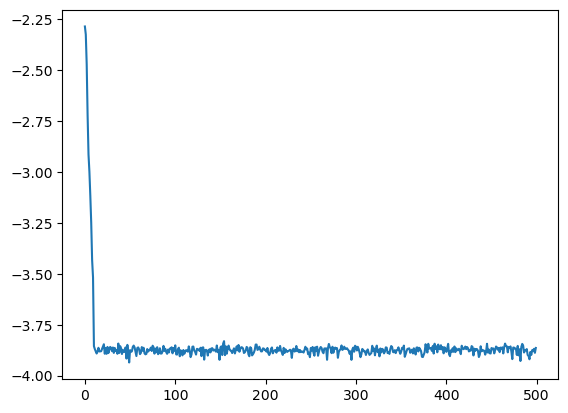

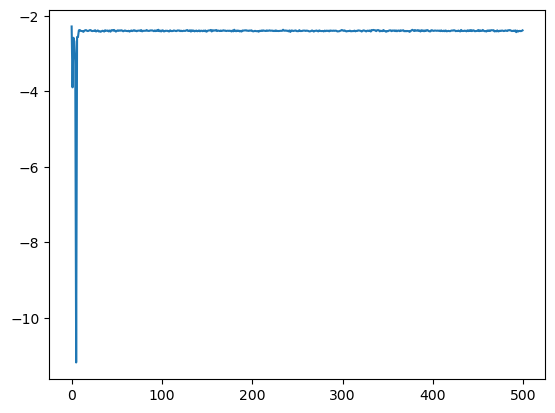

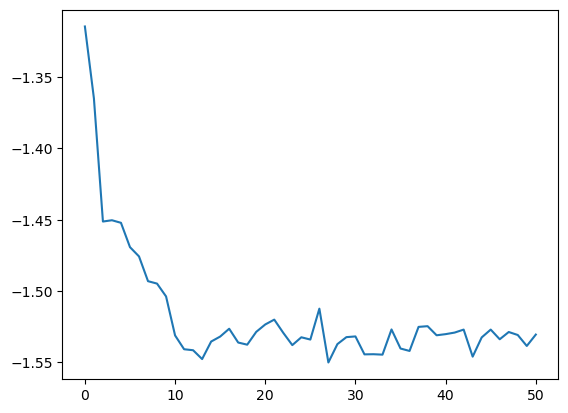

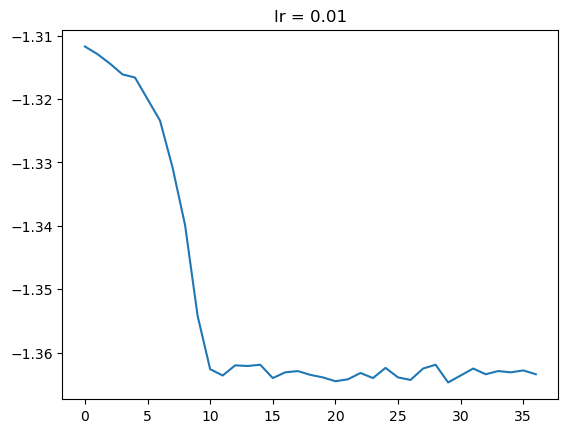

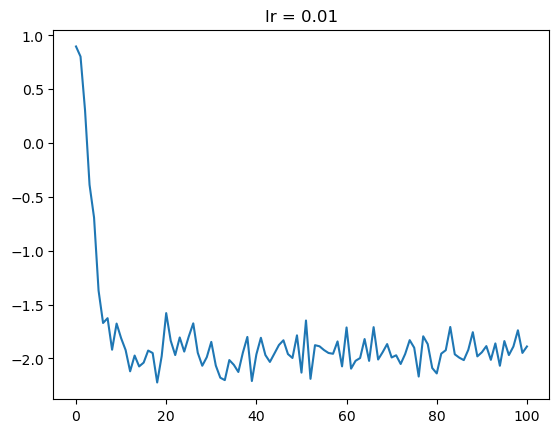

In [7]:
plt.plot(values)
plt.show()
plt.plot(values2)
plt.show()
plt.plot(values3)
plt.show()
plt.plot(values4)
plt.title("lr = 0.01")
plt.show()
plt.plot(values5)
plt.title("lr = 0.01")
plt.show()

In [6]:
Y = torch.tensor([[[ 6.3931],
        [ 9.6724],
        [ 6.0745],
        [ 8.3885],
        [ 6.9838],
        [ 5.1288],
        [14.3421],
        [-0.1680],
        [ 2.1470]]])

X = torch.tensor([[[0.6718],
         [0.5047],
         [0.3614],
         [0.4494],
         [0.6661],
         [0.4616],
         [0.2795],
         [0.3304],
         [0.2873]],

        [[0.6630],
         [0.4493],
         [0.4483],
         [0.3877],
         [0.3177],
         [0.6348],
         [0.4751],
         [0.5272],
         [0.4451]],

        [[0.5446],
         [0.4811],
         [0.3479],
         [0.5865],
         [0.4032],
         [0.3721],
         [0.4965],
         [0.3733],
         [0.5020]],

        [[0.6841],
         [0.5521],
         [0.6129],
         [0.5868],
         [0.4181],
         [0.3603],
         [0.4393],
         [0.4314],
         [0.4019]],

        [[0.6607],
         [0.4726],
         [0.4377],
         [0.5131],
         [0.5020],
         [0.5362],
         [0.3359],
         [0.5585],
         [0.4201]],

        [[0.5787],
         [0.6177],
         [0.5117],
         [0.4827],
         [0.4904],
         [0.6251],
         [0.4014],
         [0.5193],
         [0.3956]],

        [[0.5795],
         [0.4292],
         [0.4701],
         [0.5572],
         [0.3834],
         [0.3702],
         [0.3462],
         [0.5004],
         [0.5125]]])

X2 = torch.tensor([[[-0.1458],
         [-0.1499],
         [-0.1312],
         [-0.1497],
         [-0.1546],
         [-0.1505],
         [-0.1266],
         [-0.1306],
         [-0.1263]],

        [[-0.1458],
         [-0.1436],
         [-0.1467],
         [-0.1359],
         [-0.1279],
         [-0.1556],
         [-0.1528],
         [-0.1590],
         [-0.1513]],

        [[-0.1392],
         [-0.1483],
         [-0.1306],
         [-0.1559],
         [-0.1397],
         [-0.1369],
         [-0.1582],
         [-0.1370],
         [-0.1593]],

        [[-0.1457],
         [-0.1513],
         [-0.1539],
         [-0.1562],
         [-0.1445],
         [-0.1350],
         [-0.1510],
         [-0.1493],
         [-0.1462]],

        [[-0.1458],
         [-0.1469],
         [-0.1450],
         [-0.1562],
         [-0.1567],
         [-0.1586],
         [-0.1280],
         [-0.1577],
         [-0.1476]],

        [[-0.1406],
         [-0.1513],
         [-0.1533],
         [-0.1532],
         [-0.1558],
         [-0.1560],
         [-0.1429],
         [-0.1590],
         [-0.1446]],

        [[-0.1406],
         [-0.1406],
         [-0.1498],
         [-0.1569],
         [-0.1354],
         [-0.1370],
         [-0.1320],
         [-0.1589],
         [-0.1593]]])

X3 = torch.tensor([[[[ 6.3231],
        [ 9.6324],
        [ 6.0442],
        [ 8.3585],
        [ 6.9738],
        [ 5.8288],
        [14.3429],
        [-0.1180],
        [ 2.1270]],
        
        [[ 6.4931],
        [ 9.6924],
        [ 6.1742],
        [ 8.3285],
        [ 6.9238],
        [ 5.1388],
        [14.3321],
        [-0.1480],
        [ 2.1270]],

        [[ 4.4931],
        [ 8.6924],
        [ 7.1742],
        [ 9.3285],
        [ 4.9238],
        [ 3.1388],
        [11.3321],
        [-0.120],
        [ 3.1270]]],
        
        [[[ 5.3231],
        [ 8.6324],
        [ 7.0442],
        [ 8.3585],
        [ 6.2738],
        [ 5.2288],
        [14.2429],
        [-0.3180],
        [ 2.3270]],
        
        [[ 6.1931],
        [ 9.6124],
        [ 6.1742],
        [ 8.3185],
        [ 6.9138],
        [ 5.1388],
        [14.2321],
        [-0.2480],
        [ 2.2270]],

        [[ 3.4931],
        [ 8.6124],
        [ 7.1142],
        [ 9.3185],
        [ 4.9138],
        [ 3.1188],
        [11.3121],
        [-0.110],
        [ 3.1170]]]])

In [10]:
static_kernel = sigkernel.Linear_ID_Kernel()
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

Y = Y.double()
X3 = X3.double()

K_XX = signature_kernel.compute_Gram(X3, X3, sym=True, max_batch=100)
K_Xy = signature_kernel.compute_Gram(X3, Y, sym=False, max_batch=100)

#print(K_XX)
#print(K_Xy)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX_m)
print(torch.mean(K_Xy))

#K_XX_m - 2. * torch.mean(K_Xy)
print(K_XX_m - 2. * torch.mean(K_Xy))

signature_kernel.compute_scoring_rule(X3,Y)



tensor(3169.4237, dtype=torch.float64)
tensor(4.9373e+08, dtype=torch.float64)
tensor(-9.8745e+08, dtype=torch.float64)


tensor(-9.8745e+08, dtype=torch.float64)

In [7]:
X3.shape

torch.Size([2, 3, 9, 1])

In [91]:
static_kernel = sigkernel.Linear_ID_Kernel()
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

# static_kernel = sigkernel.RBFKernel(sigma=1.0)  # Experiment with different sigma values
# signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

X3 = (X3 - Y.mean()) / Y.std()
Y = (Y - Y.mean()) / Y.std()


time_vec = torch.linspace(0, 1, steps=9, device="cpu")
time_vec = time_vec.unsqueeze(0).unsqueeze(-1)  # now [1, seq_len, 1]
#print(time_vec)
y = torch.cat([Y, time_vec], dim=-1)
time_vec = time_vec.expand(3, 9, 1)  # now [batch_size, seq_len, 1]
X3 = torch.cat([X3, time_vec], dim=-1)

# print(y)
# print(X3)
print(y)
print(y.shape)
print(X3)
print(X3.shape)

X = X.double()
X2 = X2.double()
X3 = X3.double()
y = y.double()


K_XX = signature_kernel.compute_Gram(X3, X3, sym=True, max_batch=100)
K_Xy = signature_kernel.compute_Gram(X3, y, sym=False, max_batch=100)

#print(K_XX)
#print(K_Xy)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX_m)
print(torch.mean(K_Xy))

#K_XX_m - 2. * torch.mean(K_Xy)
print(K_XX_m - 2. * torch.mean(K_Xy))

signature_kernel.compute_scoring_rule(X3,y)


tensor([[[-0.0377,  0.0000],
         [ 0.7439,  0.1250],
         [-0.1137,  0.2500],
         [ 0.4379,  0.3750],
         [ 0.1031,  0.5000],
         [-0.3391,  0.6250],
         [ 1.8569,  0.7500],
         [-1.6015,  0.8750],
         [-1.0498,  1.0000]]])
torch.Size([1, 9, 2])
tensor([[[-0.0544,  0.0000],
         [ 0.7344,  0.1250],
         [-0.1209,  0.2500],
         [ 0.4307,  0.3750],
         [ 0.1007,  0.5000],
         [-0.1722,  0.6250],
         [ 1.8571,  0.7500],
         [-1.5896,  0.8750],
         [-1.0545,  1.0000]],

        [[-0.0139,  0.0000],
         [ 0.7487,  0.1250],
         [-0.0899,  0.2500],
         [ 0.4236,  0.3750],
         [ 0.0888,  0.5000],
         [-0.3367,  0.6250],
         [ 1.8545,  0.7500],
         [-1.5968,  0.8750],
         [-1.0545,  1.0000]],

        [[-0.4906,  0.0000],
         [ 0.5103,  0.1250],
         [ 0.1485,  0.2500],
         [ 0.6619,  0.3750],
         [-0.3879,  0.5000],
         [-0.8134,  0.6250],
         [ 1.13

tensor(-16.8653, dtype=torch.float64)

In [86]:
#Verified order of dimensions doesn't matter as expected

yy = np.asarray([[[ 6.3931],
        [ 9.6724],
        [ 6.0745],
        [ 8.3885],
        [ 6.9838],
        [ 5.1288],
        [14.3421],
        [-0.1680],
        [ 2.1470]]])
test = sigkernel.transform(yy,at=True)

xx = np.asarray([[[ 6.3231],
        [ 9.6324],
        [ 6.0442],
        [ 8.3585],
        [ 6.9738],
        [ 5.8288],
        [14.3429],
        [-0.1180],
        [ 2.1270]],
        
        [[ 6.4931],
        [ 9.6924],
        [ 6.1742],
        [ 8.3285],
        [ 6.9238],
        [ 5.1388],
        [14.3321],
        [-0.1480],
        [ 2.1270]],

        [[ 4.4931],
        [ 8.6924],
        [ 7.1742],
        [ 9.3285],
        [ 4.9238],
        [ 3.1388],
        [11.3321],
        [-0.120],
        [ 3.1270]]])
testxx = sigkernel.transform(xx,at=True)

print(test.shape)
print(test)
print(testxx)

testxx = torch.tensor(testxx)
test = torch.tensor(test)

K_XX = signature_kernel.compute_Gram(testxx, testxx, sym=True, max_batch=100)
K_Xy = signature_kernel.compute_Gram(testxx, test, sym=False, max_batch=100)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX_m - 2. * torch.mean(K_Xy))


signature_kernel.compute_scoring_rule(testxx,test)

(1, 9, 2)
[[[ 0.      6.3931]
  [ 0.125   9.6724]
  [ 0.25    6.0745]
  [ 0.375   8.3885]
  [ 0.5     6.9838]
  [ 0.625   5.1288]
  [ 0.75   14.3421]
  [ 0.875  -0.168 ]
  [ 1.      2.147 ]]]
[[[ 0.      6.3231]
  [ 0.125   9.6324]
  [ 0.25    6.0442]
  [ 0.375   8.3585]
  [ 0.5     6.9738]
  [ 0.625   5.8288]
  [ 0.75   14.3429]
  [ 0.875  -0.118 ]
  [ 1.      2.127 ]]

 [[ 0.      6.4931]
  [ 0.125   9.6924]
  [ 0.25    6.1742]
  [ 0.375   8.3285]
  [ 0.5     6.9238]
  [ 0.625   5.1388]
  [ 0.75   14.3321]
  [ 0.875  -0.148 ]
  [ 1.      2.127 ]]

 [[ 0.      4.4931]
  [ 0.125   8.6924]
  [ 0.25    7.1742]
  [ 0.375   9.3285]
  [ 0.5     4.9238]
  [ 0.625   3.1388]
  [ 0.75   11.3321]
  [ 0.875  -0.12  ]
  [ 1.      3.127 ]]]
tensor(4.3325e+21, dtype=torch.float64)


tensor(4.3325e+21, dtype=torch.float64)

In [1]:
torch.tensor([[[0.0000, 0.0000],
         [0.8603, 0.1111],
         [1.2131, 0.2222],
         [0.8260, 0.3333],
         [1.0749, 0.4444],
         [0.9238, 0.5556],
         [0.7243, 0.6667],
         [1.7155, 0.7778],
         [0.1544, 0.8889],
         [0.4035, 1.0000]]])

NameError: name 'torch' is not defined

In [85]:
static_kernel = sigkernel.Linear_ID_Kernel()
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

X = X.double()
X2 = X2.double()
X3 = X3.double()
Y = Y.double()

X3 = X2

K_XX = signature_kernel.compute_Gram(X3, X3, sym=True, max_batch=100)
K_Xy = signature_kernel.compute_Gram(X3, Y, sym=False, max_batch=100)

print(K_XX)
print(K_Xy)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX_m)

#K_XX_m - 2. * torch.mean(K_Xy)
print(K_XX_m - 2. * torch.mean(K_Xy))

signature_kernel.compute_scoring_rule(X3,Y)

tensor([[1.0004, 0.9999, 0.9996, 1.0000, 1.0000, 0.9999, 0.9996],
        [0.9999, 1.0000, 1.0001, 1.0000, 1.0000, 1.0000, 1.0001],
        [0.9996, 1.0001, 1.0004, 1.0000, 1.0000, 1.0001, 1.0004],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9999, 1.0000, 1.0001, 1.0000, 1.0000, 1.0000, 1.0001],
        [0.9996, 1.0001, 1.0004, 1.0000, 1.0000, 1.0001, 1.0003]],
       dtype=torch.float64)
tensor([[0.9189],
        [1.0235],
        [1.0872],
        [1.0021],
        [1.0077],
        [1.0170],
        [1.0810]], dtype=torch.float64)
tensor(1.0000, dtype=torch.float64)
tensor(-1.0393, dtype=torch.float64)


tensor(-1.0393, dtype=torch.float64)

In [4]:
yy = torch.load('results/lorenz/datasets/test_y.pty')
print(yy.shape)
print(yy[:5])

torch.Size([38, 9, 1])
tensor([[[-0.0539],
         [ 8.7413],
         [ 8.3751],
         [ 8.6316],
         [ 8.3015],
         [ 8.7187],
         [ 8.1985],
         [ 8.8413],
         [ 8.0551]],

        [[ 8.7413],
         [ 8.3751],
         [ 8.6316],
         [ 8.3015],
         [ 8.7187],
         [ 8.1985],
         [ 8.8413],
         [ 8.0551],
         [ 9.0060]],

        [[ 8.3751],
         [ 8.6316],
         [ 8.3015],
         [ 8.7187],
         [ 8.1985],
         [ 8.8413],
         [ 8.0551],
         [ 9.0060],
         [ 7.8619]],

        [[ 8.6316],
         [ 8.3015],
         [ 8.7187],
         [ 8.1985],
         [ 8.8413],
         [ 8.0551],
         [ 9.0060],
         [ 7.8619],
         [ 9.2133]],

        [[ 8.3015],
         [ 8.7187],
         [ 8.1985],
         [ 8.8413],
         [ 8.0551],
         [ 9.0060],
         [ 7.8619],
         [ 9.2133],
         [ 7.6105]]])


C:\Users\arche\AppData\Local\Temp\ipykernel_67128\3653337228.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  yy = torch.load('results/lorenz/datasets/test_y.pty')


In [5]:
xx = torch.load('results/lorenz/datasets/test_x.pty')
# xx = torch.load('results/lorenz/datasets/window10_original_lorenz63/test_x.pty')
print(xx.shape)
print(xx[:5])


torch.Size([38, 10, 1])
tensor([[[ -0.7210],
         [ -2.6933],
         [-20.9333],
         [  6.0664],
         [ 13.6956],
         [  2.3813],
         [ 12.1978],
         [ -0.6020],
         [ -0.4878],
         [ -5.8524]],

        [[ -2.6933],
         [-20.9333],
         [  6.0664],
         [ 13.6956],
         [  2.3813],
         [ 12.1978],
         [ -0.6020],
         [ -0.4878],
         [ -5.8524],
         [ -0.0539]],

        [[-20.9333],
         [  6.0664],
         [ 13.6956],
         [  2.3813],
         [ 12.1978],
         [ -0.6020],
         [ -0.4878],
         [ -5.8524],
         [ -0.0539],
         [  8.7413]],

        [[  6.0664],
         [ 13.6956],
         [  2.3813],
         [ 12.1978],
         [ -0.6020],
         [ -0.4878],
         [ -5.8524],
         [ -0.0539],
         [  8.7413],
         [  8.3751]],

        [[ 13.6956],
         [  2.3813],
         [ 12.1978],
         [ -0.6020],
         [ -0.4878],
         [ -5.8524],
  

C:\Users\arche\AppData\Local\Temp\ipykernel_67128\1223622637.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xx = torch.load('results/lorenz/datasets/test_x.pty')


In [103]:
yy = torch.load('results/lorenz/datasets/train_y.pty')
# xx = torch.load('results/lorenz/datasets/window10_original_lorenz63/test_x.pty')
print(yy.shape)
#print(yy)
yy[:,0,0].mean()
yy[:,0,0].std()

torch.Size([109, 9, 1])


C:\Users\arche\AppData\Local\Temp\ipykernel_11396\4032125966.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  yy = torch.load('results/lorenz/datasets/train_y.pty')


tensor(9.2951)

In [59]:
batch, len_x, len_y, dim = 2, 3, 3, 1
X = torch.rand((batch,len_x,dim), dtype=torch.float64, device='cuda') # shape (batch,len_x,dim)
Y = torch.rand((batch,len_y,dim), dtype=torch.float64, device='cuda') # shape (batch,len_y,dim)
Z = torch.rand((batch,len_x,dim), dtype=torch.float64, device='cuda') # shape (batch,len_y,dim)


In [65]:
X.shape   #7,10,1 v 2,3,1

torch.Size([2, 3, 1])

In [67]:
X.unsqueeze(-1).shape

torch.Size([2, 3, 1, 1])

In [62]:
import sigkernel

In [64]:
sigkernel.transform(X, at=True)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [54]:
X[:,1,:]

tensor([[0.6137]], device='cuda:0', dtype=torch.float64)

In [57]:
onesteps = []
onesteps.append(X[:,1,:])
onesteps.append(X[:,2,:])
torch.stack(onesteps,dim=0).shape

torch.Size([2, 1, 1])

In [40]:
X[1].unsqueeze(0).shape #1,3,1

torch.Size([1, 3, 1])

In [16]:
X

tensor([[[0.7415],
         [0.4726]],

        [[0.5126],
         [0.9480]],

        [[0.6342],
         [0.7511]],

        [[0.4051],
         [0.4049]],

        [[0.7773],
         [0.8625]]], device='cuda:0', dtype=torch.float64)